In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all-cleaned.csv")

In [4]:
print('Rows, columns: ', df.shape)
print('Years/state', len(df)/50)
print('YEARs', df['YEAR'].min(), '--' , df['YEAR'].max())
print('\nSTATEs\n', df['STATE'].unique(), '\n')
print('Features:\n', df.columns.tolist(), '\n')

Rows, columns:  (1487, 25)
Years/state 29.74
YEARs 1992 -- 2017

STATEs
 ['ALABAMA' 'ALASKA' 'ARIZONA' 'ARKANSAS' 'CALIFORNIA' 'COLORADO'
 'CONNECTICUT' 'DELAWARE' 'DISTRICT_OF_COLUMBIA' 'FLORIDA' 'GEORGIA'
 'HAWAII' 'IDAHO' 'ILLINOIS' 'INDIANA' 'IOWA' 'KANSAS' 'KENTUCKY'
 'LOUISIANA' 'MAINE' 'MARYLAND' 'MASSACHUSETTS' 'MICHIGAN' 'MINNESOTA'
 'MISSISSIPPI' 'MISSOURI' 'MONTANA' 'NEBRASKA' 'NEVADA' 'NEW_HAMPSHIRE'
 'NEW_JERSEY' 'NEW_MEXICO' 'NEW_YORK' 'NORTH_CAROLINA' 'NORTH_DAKOTA'
 'OHIO' 'OKLAHOMA' 'OREGON' 'PENNSYLVANIA' 'RHODE_ISLAND' 'SOUTH_CAROLINA'
 'SOUTH_DAKOTA' 'TENNESSEE' 'TEXAS' 'UTAH' 'VERMONT' 'VIRGINIA'
 'WASHINGTON' 'WEST_VIRGINIA' 'WISCONSIN' 'WYOMING' 'AMERICAN_SAMOA'
 'BUREAU_OF_INDIAN_AFFAIRS' 'DOD_DOMESTIC' 'DOD_OVERSEAS' 'GUAM'
 'NORTHERN_MARIANAS' 'PUERTO_RICO' 'VIRGIN_ISLANDS' 'BI' 'DD'
 'NORTHERN_MARIANA_ISLANDS' 'DEPARTMENT_OF_DEFENSE'
 'BUREAU_OF_INDIAN_EDUCATION' 'DEPARTMENT_OF_DEFENSE_EDUCATION_ACTIVITY'
 'U.S._VIRGIN_ISLANDS' 'DOD_(OVERSEAS_AND_DOMESTIC_COM

In [5]:
df.head(5)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


## Insight 0

(23, 23)


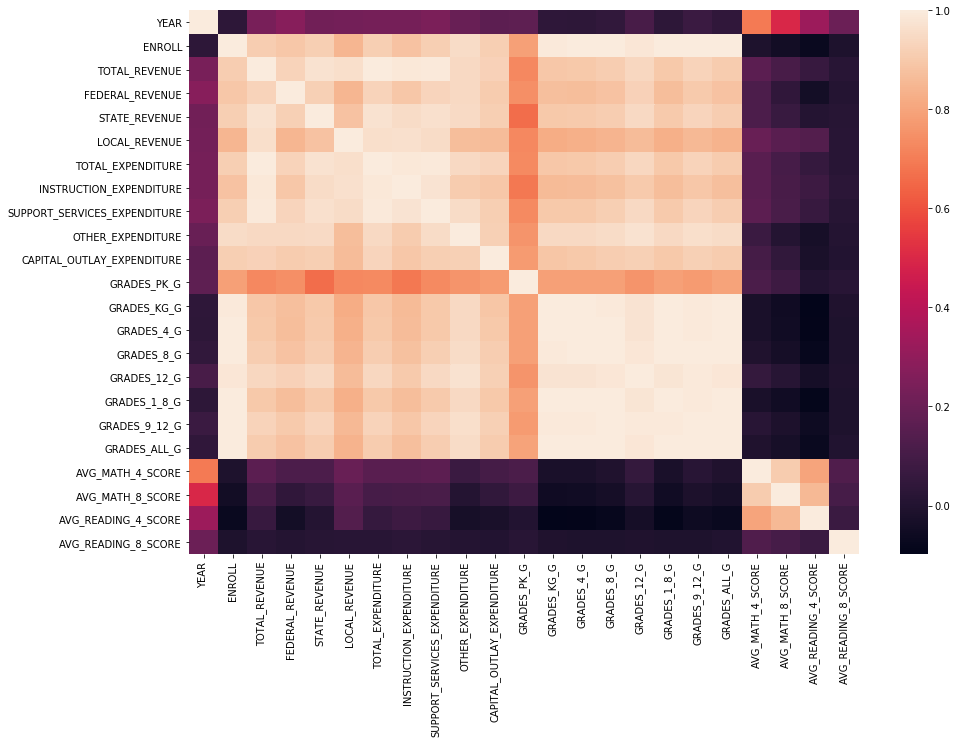

In [6]:
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr)

<Figure size 432x288 with 0 Axes>

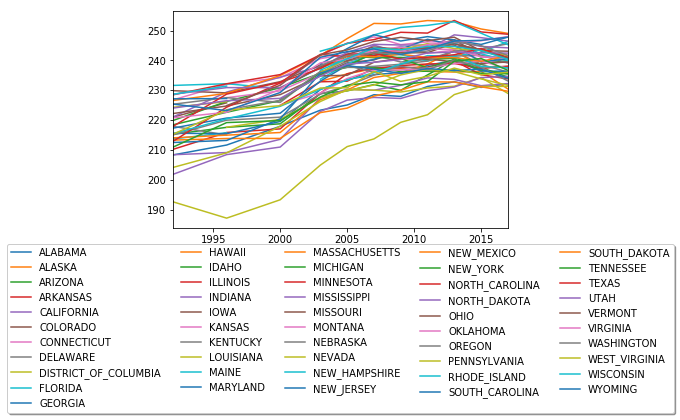

In [7]:
plt.figure()
df.pivot_table('AVG_MATH_4_SCORE', index='YEAR', columns='STATE', aggfunc='median').plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

# Basic Feature Building

In [8]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

fracn_exp_INSTRUCTION_EXPENDITURE
fracn_exp_SUPPORT_SERVICES_EXPENDITURE
fracn_exp_OTHER_EXPENDITURE
fracn_exp_CAPITAL_OUTLAY_EXPENDITURE


In [9]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

fracn_rev_FEDERAL_REVENUE
fracn_rev_STATE_REVENUE
fracn_rev_LOCAL_REVENUE


In [10]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

fracn_enroll_GRADES_PK_G
fracn_enroll_GRADES_KG_G
fracn_enroll_GRADES_4_G
fracn_enroll_GRADES_8_G
fracn_enroll_GRADES_12_G
fracn_enroll_GRADES_1_8_G
fracn_enroll_GRADES_9_12_G


(37, 37)


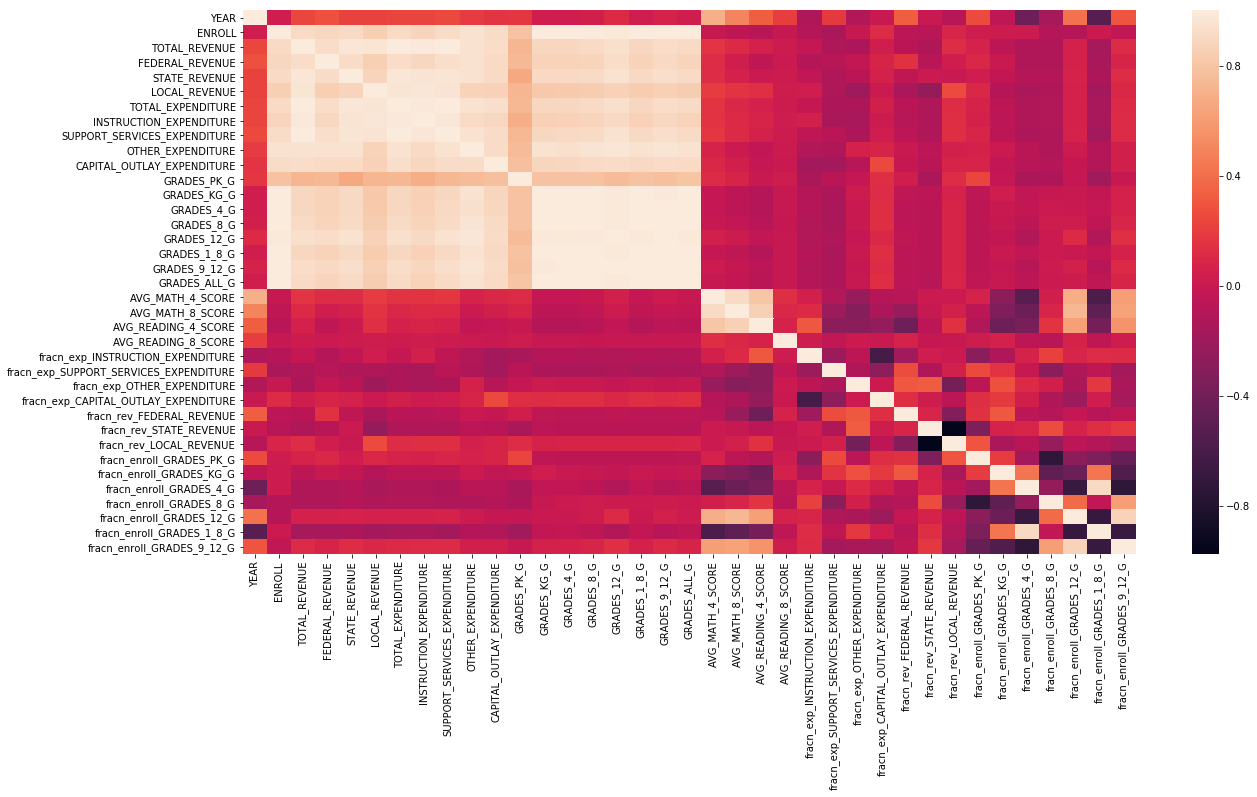

In [11]:
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr)

# RandomForest

In [12]:
n_splits=20
ts_cv = TimeSeriesSplit(n_splits=n_splits)
print(ts_cv)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = np.zeros(n_splits)
test_score = np.zeros(n_splits)

df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
df1 = pd.get_dummies(df1, columns=['STATE'])
y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    Y_rf=rf_model.predict(X_test)
    train_score[index]=rf_model.score(X_train,y_train) #Train score
    test_score[index]=rf_model.score(X_test,y_test) #Test score
    index+=1
index_list=np.arange(index)

TimeSeriesSplit(max_train_size=None, n_splits=20)


Text(0.5, 1.0, 'Learning Curve')

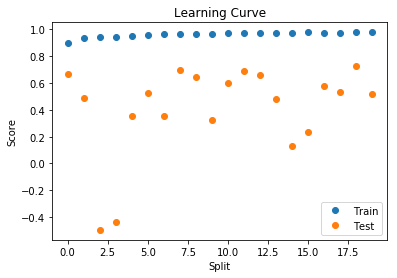

In [13]:
plt.plot(index_list,train_score,'o', label="Train")
plt.plot(index_list,test_score,'o', label="Test")
plt.xlabel("Split")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title('Learning Curve')

In [14]:
model=RandomForestRegressor()

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

param_range=[4,5,6,7,8,9,10,20,30,40,50,60]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, \
                     cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

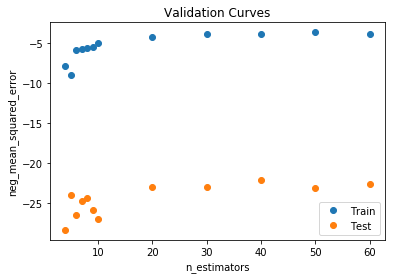

In [15]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

In [16]:
model=RandomForestRegressor(n_estimators=20)

num_splits=20
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=20), 
                   cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

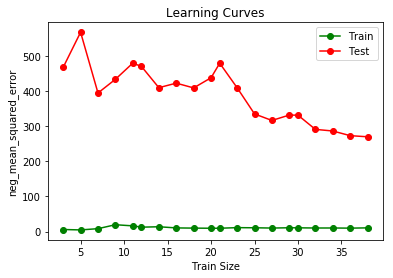

In [17]:
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("neg_mean_squared_error")
plt.title("Learning Curves")
plt.legend(loc="best")

In [18]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [19]:
rf_model.score(X,y)

0.9773956829250603

# Insight 1a

In [20]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

,importance
YEAR,0.427824
fracn_enroll_GRADES_12_G,0.193749
fracn_rev_FEDERAL_REVENUE,0.071887
fracn_exp_SUPPORT_SERVICES_EXPENDITURE,0.024707
fracn_rev_LOCAL_REVENUE,0.020565
fracn_exp_OTHER_EXPENDITURE,0.016191
fracn_enroll_GRADES_8_G,0.015186
fracn_enroll_GRADES_PK_G,0.012363
STATE_REVENUE,0.012150
fracn_enroll_GRADES_KG_G,0.011906


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),
 <a list of 83 Text xticklabel objects>)

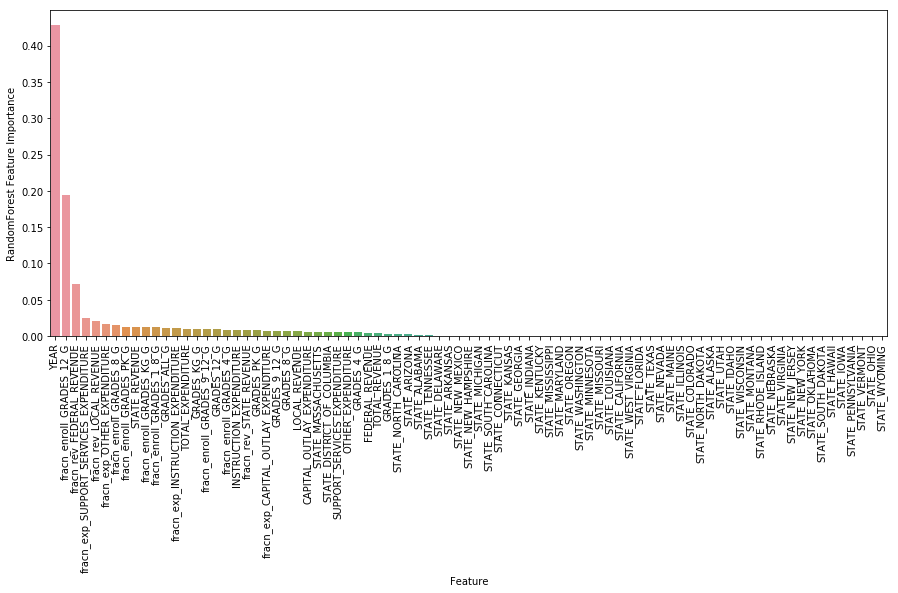

In [21]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x=feature_importances_rf.index, y=feature_importances_rf['importance'])
ax.set_xlabel('Feature')
ax.set_ylabel('RandomForest Feature Importance')
plt.xticks(rotation=90)

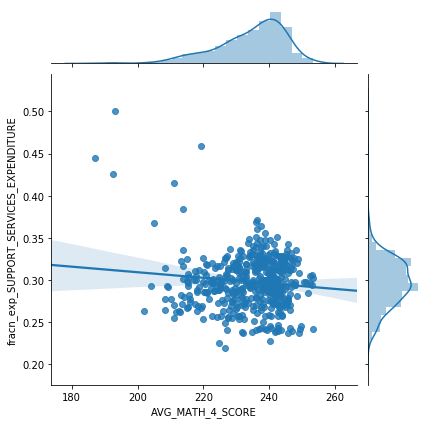

In [22]:
sns.jointplot(x='AVG_MATH_4_SCORE', y='fracn_exp_SUPPORT_SERVICES_EXPENDITURE', kind='reg', data=df)

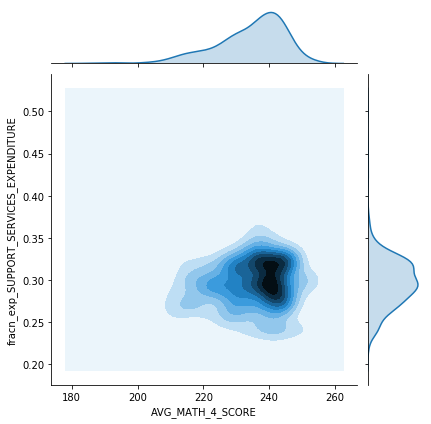

In [23]:
sns.jointplot(x='AVG_MATH_4_SCORE', y='fracn_exp_SUPPORT_SERVICES_EXPENDITURE', kind='kde', data=df)

# Lasso

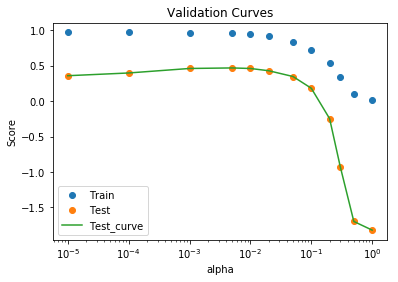

In [24]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

(30,) (30, 5) (30, 5)


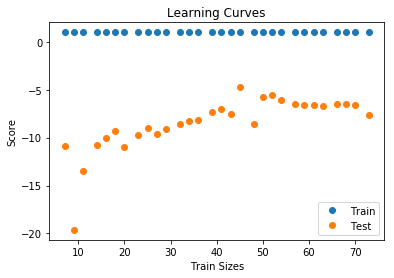

In [25]:
model=linear_model.Lasso(alpha=0.01, normalize=True)
#lasso_model.fit(X, y)  
#Y_lasso=lasso_model.predict(X)

num_splits=5
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [26]:
"""Plot test data fit"""

'Plot test data fit'

Text(0, 0.5, 'y')

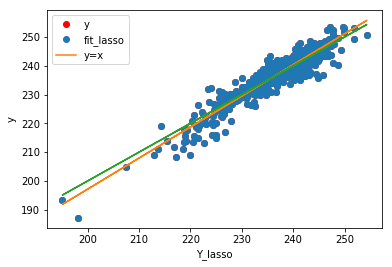

In [27]:

lasso_model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [28]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

(83,)
(83,)
[   1.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.    0.   -0.
   -0.   -0.   -0.   -0.   -0.   -0.   -0.  -35.  -33.    4.   -0.   -0.
    0.    0.    0. -297.   58.  155.   -0.   58.   -6.   -1.   -3.   -1.
   -8.    2.    2.    0.  -13.    0.   -0.    0.    0.   -1.    4.   -0.
    3.   -0.   -1.    0.    0.    8.   -1.    2.   -5.   -0.    0.   -1.
   -2.    5.    5.   -7.   -2.    5.    0.    3.    0.   -0.   -0.   -0.
   -0.    0.   -2.    4.    0.    0.    2.    0.   -2.    0.    3.]


[(-297.0, 'fracn_enroll_GRADES_4_G'),
 (-35.0, 'fracn_exp_SUPPORT_SERVICES_EXPENDITURE'),
 (-33.0, 'fracn_exp_OTHER_EXPENDITURE'),
 (-13.0, 'STATE_DISTRICT_OF_COLUMBIA'),
 (-8.0, 'STATE_CALIFORNIA'),
 (-7.0, 'STATE_NEW_MEXICO'),
 (-6.0, 'STATE_ALABAMA'),
 (-5.0, 'STATE_MISSISSIPPI'),
 (-3.0, 'STATE_ARIZONA'),
 (-2.0, 'STATE_NEVADA'),
 (-2.0, 'STATE_NEW_YORK'),
 (-2.0, 'STATE_TENNESSEE'),
 (-2.0, 'STATE_WEST_VIRGINIA'),
 (-1.0, 'STATE_ALASKA'),
 (-1.0, 'STATE_ARKANSAS'),
 (-1.0, 'STATE_ILLINOIS'),
 (-1.0, 'STATE_LOUISIANA'),
 (-1.0, 'STATE_MICHIGAN'),
 (-1.0, 'STATE_NEBRASKA'),
 (0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (-0.0, 'FEDERAL_REVENUE'),
 (-0.0, 'GRADES_12_G'),
 (-0.0, 'GRADES_1_8_G'),
 (-0.0, 'GRADES_4_G'),
 (-0.0, 'GRADES_8_G'),
 (-0.0, 'GRADES_9_12_G'),
 (-0.0, 'GRADES_ALL_G'),
 (-0.0, 'GRADES_KG_G'),
 (0.0, 'GRADES_PK_G'),
 (-0.0, 'INSTRUCTION_EXPENDITURE'),
 (-0.0, 'LOCAL_REVENUE'),
 (-0.0, 'OTHER_EXPENDITURE'),
 (0.0, 'STATE_DELAWARE'),
 (0.0, 'STATE_FLORIDA'),
 (-0.0, 'STATE

# Scaled Lasso

## Insight 1b

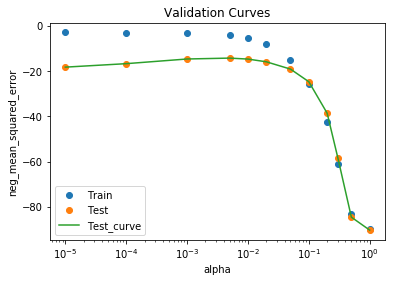

In [29]:
# Lasso 
# Validation Curve
# Scaled Features

scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(normalize=True)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]
"""
#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X_transformed, y=y, param_name="alpha", \
    param_range=param_range, cv=ts_cv, n_jobs=-1, scoring='neg_mean_squared_error')

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("neg_mean_squared_error")
plt.title("Validation Curves")
plt.legend(loc="best")

In [30]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

(83,)
(83,)
[ 5. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -1. -1.  0. -0. -0.  0.  0.  0. -1.  0.  1. -0.  1. -1. -0. -0. -0.
 -1.  0.  0.  0. -2.  0. -0.  0.  0. -0.  1. -0.  0. -0. -0.  0.  0.  1.
 -0.  0. -1. -0.  0. -0. -0.  1.  1. -1. -0.  1.  0.  0.  0. -0. -0. -0.
 -0.  0. -0.  1.  0.  0.  0.  0. -0.  0.  0.]


[(-1.8207775043829786, 'STATE_DISTRICT_OF_COLUMBIA'),
 (-1.1001269838608005, 'fracn_exp_SUPPORT_SERVICES_EXPENDITURE'),
 (-1.0792942675917485, 'fracn_enroll_GRADES_4_G'),
 (-1.0439533484154961, 'STATE_CALIFORNIA'),
 (-0.9882559389328859, 'STATE_NEW_MEXICO'),
 (-0.8628991915948585, 'STATE_ALABAMA'),
 (-0.770191352970044, 'STATE_MISSISSIPPI'),
 (-0.5091425091006798, 'fracn_exp_OTHER_EXPENDITURE'),
 (-0.46037125948176094, 'STATE_ARIZONA'),
 (-0.32726928384518933, 'STATE_TENNESSEE'),
 (-0.25563409144645666, 'STATE_WEST_VIRGINIA'),
 (-0.2286617633445505, 'STATE_NEW_YORK'),
 (-0.2260758715536255, 'STATE_NEVADA'),
 (-0.19365099788767737, 'STATE_NEBRASKA'),
 (-0.18068591987192414, 'STATE_LOUISIANA'),
 (-0.1185630513668399, 'STATE_ARKANSAS'),
 (-0.11164511392343696, 'STATE_ALASKA'),
 (-0.07881515318310797, 'STATE_ILLINOIS'),
 (-0.07295982513773792, 'STATE_MICHIGAN'),
 (-0.0613012185479484, 'STATE_OREGON'),
 (-0.007091329361182915, 'STATE_GEORGIA'),
 (0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (-0.0, 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),
 <a list of 83 Text xticklabel objects>)

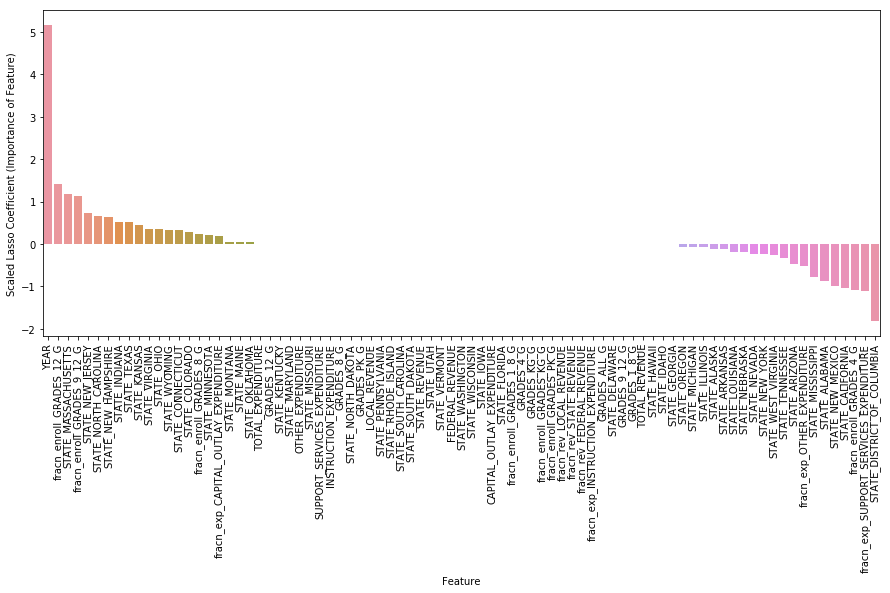

In [31]:
lasso_coef_df = pd.DataFrame(lasso_coef_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['lasso_coefs']).sort_values('lasso_coefs',ascending=False)

plt.figure(figsize=(15,6))
ax = sns.barplot(x=lasso_coef_df.index, y=lasso_coef_df['lasso_coefs'])
ax.set_xlabel('Feature')
ax.set_ylabel('Scaled Lasso Coefficient (Importance of Feature)')
plt.xticks(rotation=90)

In [32]:
lasso_coef_df.head(10)

,lasso_coefs
YEAR,5.168701
fracn_enroll_GRADES_12_G,1.415746
STATE_MASSACHUSETTS,1.167387
fracn_enroll_GRADES_9_12_G,1.139305
STATE_NEW_JERSEY,0.728423
STATE_NORTH_CAROLINA,0.668959
STATE_NEW_HAMPSHIRE,0.628260
STATE_INDIANA,0.524901
STATE_TEXAS,0.512131
STATE_KANSAS,0.454964


In [33]:
lasso_coef_df.tail(10)

,lasso_coefs
STATE_TENNESSEE,-0.327269
STATE_ARIZONA,-0.460371
fracn_exp_OTHER_EXPENDITURE,-0.509143
STATE_MISSISSIPPI,-0.770191
STATE_ALABAMA,-0.862899
STATE_NEW_MEXICO,-0.988256
STATE_CALIFORNIA,-1.043953
fracn_enroll_GRADES_4_G,-1.079294
fracn_exp_SUPPORT_SERVICES_EXPENDITURE,-1.100127
STATE_DISTRICT_OF_COLUMBIA,-1.820778


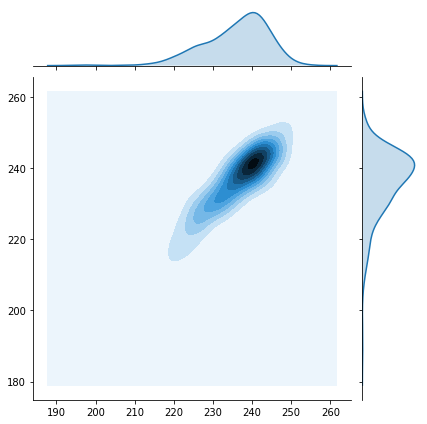

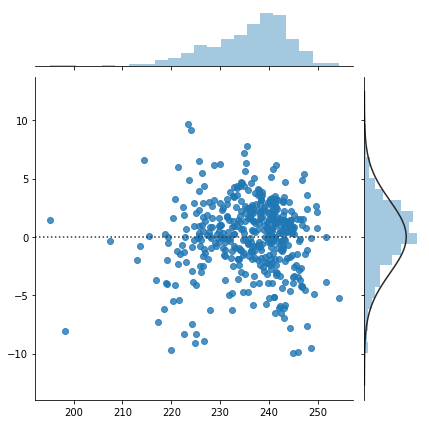

In [34]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

In [35]:
"""
Can I predict test scores for a year?

Handle time better. Time_series_split

Time trends: 
-Scores
-Populations
-Revenues
-Expenditures

Delta from previous time point as feature?

Features:
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...


"""

'\nCan I predict test scores for a year?\n\nHandle time better. Time_series_split\n\nTime trends: \n-Scores\n-Populations\n-Revenues\n-Expenditures\n\nDelta from previous time point as feature?\n\nFeatures:\n-Elite? financials, location, \n-Good school? school history, tax rev, district\n-Trends in time? Deltas in time. more money, more students, higher scores, ...\n\n\n'